**Chapter 3 – Klassifikation**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

**Warnung:** Seit Scikit-Learn Version 0.24 gibt `fetch_openml()` ein Pandas `DataFrame` zurück. Um weiterhin NumPy Arrays zu erhalten, setzen wir hier explizit den Parameter `as_frame` auf `False`.

In [2]:
# Lade MNIST mittels fetch_openml
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Speichere die Daten in X und das target in y
X, y = mnist["data"], mnist["target"]

In [4]:
# Betrachte die Dimensionen von X und y
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
# Wie kommen die 784 Dimensionen der Bilder zustande?
28 * 28

784

Es gibt 70.000 Bilder und jedes Bild hat insgesamt 784 Feature. 784, weil jedes Bild ein 28 x 28 Pixel Graubild ist, jedes Pixel besitzt einen Wert zwischen 0 (weiß) und 255 (schwarz). 

Saving figure some_digit_plot


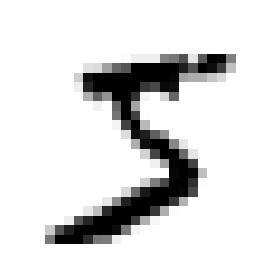

In [7]:
# Visualisiere ein Bild mit matplotlib und der Hilfsfunktion imshow
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")

In [8]:
# Betrachte das dazugehörige Label
y[0]

'5'

In [9]:
# Wandle die Label in eine Zahl um
y = y.astype(np.uint8)

In [10]:
# Schreibe eine Hilsfunktion für die Anzeige eines Bildes
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
# EXTRA
# Schreibe eine Hilfsfunktion für die Anzeige von mehreren MNIST Beispielen
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


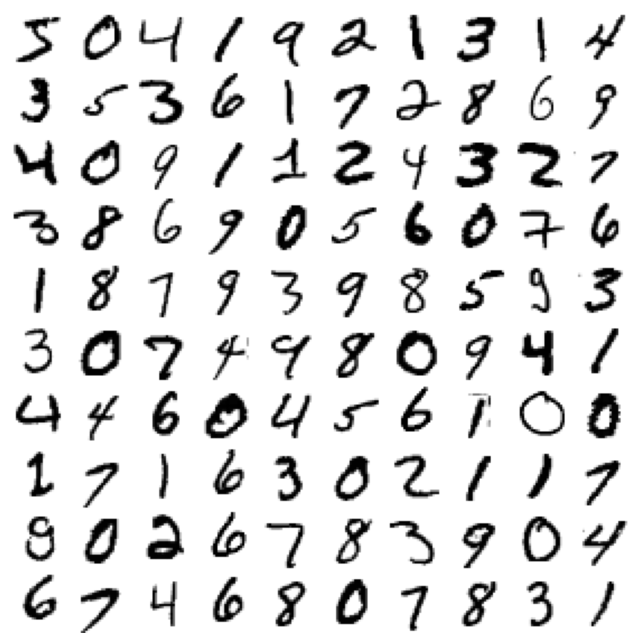

In [12]:
# Nutze die obigen Hilfsfunktionen, um 10 x 10 Beispiele auszugeben
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")

In [13]:
# Der MNIST Datensatz enthält 60.000 Trainingsbilder und 10.000 Testbilder
# Diese speichern wir in getrennten Trainings- und Testdatensätzen
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Einen binären Klassifikator trainieren

Für den Moment werden wir noch nicht versuchen, alle 10 Klassen auf einmal vorherzusagen. Stattdessen vereinfachen wir das Problem und wollen zunächst ein Modell aufstellen, dass die Zahl 5 von allen anderen unterscheiden kann.

In [14]:
# Erstelle einen target-Vektor für den Trainings- und Testdatensatz
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Anmerkung**: Einige Hyperparameter werden einen anderen Default-Wert in zukünftigen Versionen von Scikit-Learn haben, bspw. die Parameter `max_iter` und `tol`. Um auf der sicheren Seite zu sein, setzen wir diese Hyperparameter explizit auf die zukünftigen Default-Werte.

In [15]:
# Trainiere einen Stochastic Gradient Descent (SGD) classifier auf den Trainingsdaten
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # Anmerkung zu random_state: in Produktion auf None setzen
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
# Nutze den SGD Classifier für Vorhersagen
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

In [17]:
# Bestimme die Performance des Modells durch CV
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Ist eine Accuracy von über 95% gut oder schlecht? Und wenn gut, wie gut? 
Vergleichen wir diesen Wert zunächst mit einer simplen Baseline:

# Performance-Maße

Klassifikatoren zu evaluieren ist oftmals deutlich schwieriger als Regressoren, daher wird ein Großteil dieses Kapitels diesem Thema gewidmet.

## Measuring Accuracy Using Cross-Validation

Cross-Validation ist ein guter Weg, um ganz allgemein Modelle zu evaluieren. 

In [18]:
# Exkurs: CV selbst gemacht mit StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


**Anmerkung**: `shuffle=True` fehlt fälschlicherweise in den Codebeispielen im Buch.

In [19]:
# Wir bauen uns einen einfachen BasisEstimator, der immer 0 (negative Klasse, also Nicht-5) vorhersagt
# Das dient uns als Baseline für alle zu entwickelnden Modelle
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
# Jetzt testen wir unseren Baseline Estimator ebenfalls mittels CV
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Unser einfaches Basismodell hat ebenfalls eine Genauigkeit von über 90%! Dies liegt natürlich daran, dass wir ein sehr unbalancierten Datensatz haben, bei dem nur 10% der Daten Bilder von 5en sind, der Rest nicht. Wenn wir daher einfach 0 vorhersagen, liegen wir in 90% der Fälle richtig.

**Warnung**: Alle Ausgaben in diesem und anderen Notebooks können leicht von denen im Buch abweichen. Keine Sorge, das ist in Ordnung! Dafür gibt es mehrere Gründe:

* Erstens entwickeln sich Scikit-Learn und andere Bibliotheken weiter, und die Algorithmen werden weiter optimiert, was das genaue Ergebnis, das Sie erhalten, verändern kann. Wenn Sie die neueste Version von Scikit-Learn verwenden (und im Allgemeinen sollten Sie das auch tun), werden Sie wahrscheinlich nicht genau dieselbe Version verwenden, die ich verwendet habe, als ich das Buch oder dieses Notebook geschrieben habe, daher der Unterschied. Ich versuche, dieses Notebook einigermaßen auf dem neuesten Stand zu halten, aber ich kann die Zahlen in Ihrem Exemplar des Buches nicht ändern.
* Zweitens sind viele Trainingsalgorithmen stochastisch, d. h. sie beruhen auf dem Zufallsprinzip. Im Prinzip ist es möglich, konsistente Ergebnisse von einem Zufallszahlengenerator zu erhalten, indem man den Seed setzt, aus dem er die Pseudo-Zufallszahlen generiert (deshalb sieht man `random_state=42` oder `np.random.seed(42)` ziemlich oft). Manchmal reicht dies jedoch aufgrund der anderen hier aufgeführten Faktoren nicht aus.
* Drittens, wenn der Trainingsalgorithmus über mehrere Threads (wie bei einigen in C implementierten Algorithmen) oder über mehrere Prozesse läuft (z.B. bei Verwendung des Arguments `n_jobs`), dann ist die genaue Reihenfolge, in der die Operationen ausgeführt werden, nicht immer garantiert, und daher kann das genaue Ergebnis leicht variieren.
* Schließlich können auch andere Dinge eine perfekte Reproduzierbarkeit verhindern, wie Python-Dicts und -Sets, deren Reihenfolge über mehrere Sitzungen hinweg nicht garantiert ist, oder die Reihenfolge der Dateien in einem Verzeichnis, die ebenfalls nicht garantiert ist.

## Die Konfusionsmatrix

Deutlich aufschlussreicher als eine simple Genauigkeit ist die Konfusionsmatrix. Dabei schaut man sich an, wie oft eine Klasse A fälschlicherweise für eine andere Klasse B gehalten wird (und umgekehrt). 
Um eine Konfusionsmatrix aufzustellen, brauchen wir die Vorhersagen des Modells. Daher nutzen wir nicht `cross_val_score`, sondern `cross_val_predict`.

In [21]:
# Nutze cross_val_predict, um Vorhersagen des Modells zu erhalten
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
# Nutze die Funktion confusion_matrix von sklearn für die Erstellung
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Jede Zeile in der Konfusionmatrix repräsentiert eine existierende Klasse, während jede Spalte für eine vorhergesgate Klasse steht. Die erste Zeile fasst die Ergebnisse für die Klasse 0 (negative Klasse) zusammen: 53.892 wurden korrekt vorhergesagt als nicht-5 (true negatives), und 687 wurden falsch klassifiziert als 5 (false positives). Die zweite Zeile steht für die 5er (positive Klasse): 1891 wurden falsch als nicht-5 klassifiziert (false negatives), während 3530 korrekt als 5 erkanntw urden (true positives). 

In [23]:
# Konfusionsmatrix für den Fall, dass Vorhersagen exakt mit den wahren Labels übereinstimmen
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Man kann aus der Konfusionsmatrix viele weitere Metriken ableiten:
- Precision: Genauigkeit der positiven Vorhersagen
  $$ \text{precision} = \cfrac{TP}{TP + FP} $$
- Recall oder Sensitivität oder true positive rate (TPR): Anteil der wahren positiven Instanzen, die korrekt vom Klassifikator detektiert wurden
  $$ \text{recall} = \cfrac{TP}{TP+FN} $$

<center><img src="https://i.ibb.co/Kr3RDYC/1-jx-CBHGWut-Do4w-LSca-Lt-U4-Q.png"></center>

## Precision und Recall

In [24]:

# Lade Precision und Recall von sklearn.metrics
from sklearn.metrics import precision_score, recall_score

In [25]:
# Zuerst berechnen wir die Precision für unser Modell
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
# Und vergleichen das Ergebnis mit der Berechnung von Hand aus der Konfusion-Matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [27]:
# Jetzt berechnen wir den Recall
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [28]:
# Und vergleichen auch hier das Ergebnis mit der Berechnung von Hand aus der Konfusion-Matrix
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

Jetzt sieht unser 5-Detektor nicht mehr so glänzend aus, wie er es tat, als wir nur die Genauigkeit untersuchten. Wenn das Modell behauptet, ein Bild stelle eine 5 dar, liegt es nur in 83,7 % der Fälle richtig. Außerdem erkennt es nur 65,1 % der 5en.

Häufig ist es sinnvoll, Precision und Recall in einer einzigen Metrik, dem F1-Score, zusammenzufassen, insbesondere wenn Sie eine einfache Möglichkeit zum Vergleich zweier Klassifikatoren benötigen. Der F1-Score ist das harmonische Mittel aus Precision und Recall (Gleichung 3-3). Während beim normalen Mittelwert alle Werte gleich behandelt werden, werden beim harmonischen Mittelwert niedrige Werte viel stärker gewichtet. Infolgedessen erhält der Klassifikator nur dann einen hohen F1-Score, wenn sowohl Recall als auch Precision hoch sind:

$$ F_1 = \cfrac{2}{\cfrac{1}{\text{precision}} + \cfrac{1}{\text{recall}}} = 2 \times \cfrac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \cfrac{TP}{TP + \cfrac{FN + FP}{2}} $$

In [29]:
# Importiere die F1-Metrik von sklearn und berechne den Score für unseren Klassifikator
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [30]:
# Und vergleichen das Ergebnis mit der Berechnung von Hand aus der Konfusion-Matrix
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

Der F1-Score bevorzugt Klassifikatoren, die eine ähnliche Precision und einen ähnlichen Recall aufweisen. Das ist nicht immer das, was Sie wollen: In manchen Kontexten ist die Precision am wichtigsten, in anderen Kontexten ist der Recall am wichtigsten. Wenn Sie beispielsweise einen Klassifikator trainiert haben, um Videos zu erkennen, die für Kinder ungefährlich sind, würden Sie wahrscheinlich einen Klassifikator bevorzugen, der viele gute Videos ablehnt (niedrige Rückrufquote), aber nur sichere Videos behält (hohe Genauigkeit), anstatt einen Klassifikator, der eine viel höhere Rückrufquote hat, aber einige wirklich schlechte Videos in Ihrem Produkt erscheinen lässt (in solchen Fällen möchten Sie vielleicht sogar eine menschliche Pipeline hinzufügen, um die Videoauswahl des Klassifikators zu überprüfen). Nehmen wir andererseits an, Sie trainieren einen Klassifikator, um Ladendiebe in Überwachungsbildern zu erkennen: Es ist wahrscheinlich in Ordnung, wenn Ihr Klassifikator nur eine Precision von 30 % hat, solange er eine Auffindbarkeit von 99 % hat (sicher, das Sicherheitspersonal wird ein paar falsche Alarme erhalten, aber fast alle Ladendiebe werden erwischt).

Leider kann man nicht beides haben: Je höher die Precision, desto geringer der Recall und umgekehrt. Dies wird als Kompromiss zwischen Precision und Rückruf bezeichnet.

## Precision/Recall Trade-off

Um diesen Trade-off zu verstehen, wollen wir uns ansehen, wie der SGDClassifier seine Klassifizierungsentscheidungen trifft. Für jede Instanz berechnet er eine Punktzahl auf der Grundlage einer **Entscheidungsfunktion**. Wenn diese Punktzahl größer als ein Schwellenwert ist, wird die Instanz der positiven Klasse zugeordnet, andernfalls der negativen Klasse. Abbildung 3-3 zeigt einige Ziffern, die von der niedrigsten Punktzahl auf der linken Seite bis zur höchsten Punktzahl auf der rechten Seite angeordnet sind. Angenommen, der Entscheidungsschwellenwert befindet sich am mittleren Pfeil (zwischen den beiden 5en): Rechts von diesem Schwellenwert finden Sie 4 echte positive Ergebnisse (tatsächliche 5en) und 1 falsches positives Ergebnis (tatsächlich eine 6). Bei diesem Schwellenwert liegt die Genauigkeit also bei 80 % (4 von 5). Von den 6 tatsächlichen 5en erkennt der Klassifikator jedoch nur 4, so dass die Wiedererkennung 67 % beträgt (4 von 6). Wenn Sie den Schwellenwert anheben (auf den Pfeil rechts verschieben), wird aus dem falsch positiven Ergebnis (der 6) ein richtiges negatives Ergebnis, wodurch sich die Genauigkeit erhöht (in diesem Fall auf 100 %), aber ein richtiges positives Ergebnis wird zu einem falsch negativen Ergebnis, wodurch sich die Rückrufquote auf 50 % verringert. Umgekehrt erhöht eine Senkung des Schwellenwerts den Recall und verringert die Precision.

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0303.png)

In Scikit-Learn können Sie den Schwellenwert nicht direkt festlegen, aber Sie haben Zugriff auf die Entscheidungsergebnisse, die zur Erstellung von Vorhersagen verwendet werden. Anstatt die `predict()`-Methode des Klassifikators aufzurufen, können Sie dessen `decision_function()`-Methode aufrufen, die für jede Instanz eine Punktzahl zurückgibt, und dann einen beliebigen Schwellenwert verwenden, um auf der Grundlage dieser Punktzahlen Vorhersagen zu treffen:

In [31]:
# Nutze die `decision_function()`-Methode des Klassifikators anhand eines Beispiels
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
# Prüfe die Vorhersage für einen Schwellenwert von 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

In [34]:
# Verändere den Schwellenwert auf 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Wie entscheiden Sie, welcher Schwellenwert zu verwenden ist? Verwenden Sie zunächst die Funktion `cross_val_predict()`, um die Werte aller Instanzen im Trainingssatz zu erhalten, aber geben Sie diesmal an, dass Sie Entscheidungswerte anstelle von Vorhersagen zurückgeben möchten:

In [35]:
# Nutze die Methode `cross_val_predict` von sklearn mit dem Parameter `method="decision_function"`, 
# um statt der Label die tatsächlichen Scores zu bekommen
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Mit diesen Werten können Sie mit der Funktion `precision_recall_curve()` die Precision und den Rückruf für alle möglichen Schwellenwerte berechnen:

In [36]:
# Visualisiere den Trade-off zwischen precision und recall mit der Hilfsfunktion `precision_recall_curve` von sklearn
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


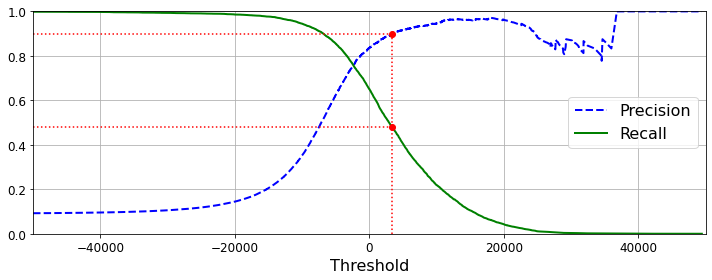

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


# Zeichne die eigentliche precision-recall-Kurve
plt.figure(figsize=(10, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Füge beispielhaft Markierungen ein wo Precision 90 % beträgt -> wie lautet der Recall?
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown

Eine weitere Möglichkeit, einen guten Kompromiss zwischen Precision und Recall zu finden, besteht darin, die Precision direkt gegen den Recall aufzutragen, wie in Abbildung 3-5 gezeigt (der gleiche Schwellenwert wie zuvor ist hervorgehoben).

Saving figure precision_vs_recall_plot


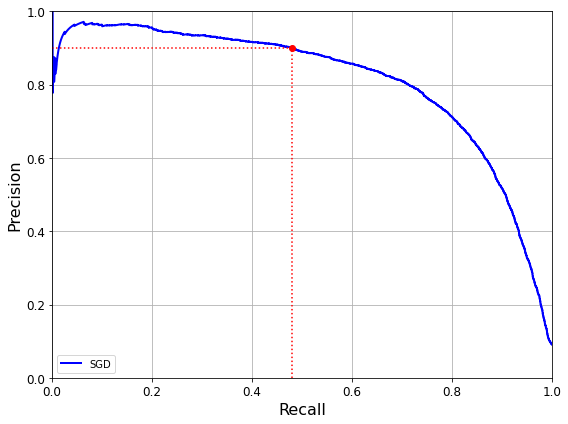

In [38]:
# Trage die Precision gegen den Recall auf
def plot_precision_vs_recall(precisions, recalls, label=""):
    plt.plot(recalls, precisions, "b-", linewidth=2, label=label)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.legend(loc="lower left")

# Plotte die Kurve
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls, "SGD")

# Füge eine Markierung für 90 % Precision hinzu
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")

Sie sehen, dass die Genauigkeit bei etwa 80 % Recall stark abnimmt. Sie werden wahrscheinlich einen Kompromiss zwischen Precision und Recall kurz vor diesem Abfall wählen wollen, z. B. bei etwa 60 % Recall. Aber natürlich hängt die Wahl von Ihrem Projekt ab.

Angenommen, Sie wollen eine Precision von 90 % erreichen. Sie sehen sich das erste Diagramm an und stellen fest, dass Sie einen Schwellenwert von etwa 8.000 verwenden müssen. Um genauer zu sein, können Sie nach dem niedrigsten Schwellenwert suchen, der eine Genauigkeit von mindestens 90 % gewährleistet (np.argmax() liefert Ihnen den ersten Index des Maximalwerts, d. h. in diesem Fall den ersten wahren Wert):

In [39]:
# Welcher Threshold führ zu einer Precision von min. 90 %?
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
threshold_90_precision

3370.0194991439557

In [41]:
# Anstatt den Standard-Threshold von 0 zu wählen, nutzen wir den Threshold für eine Precision von 90 %, um y vorherzusagen
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Wenn jemand sagt: "Lassen Sie uns eine Genauigkeit von 99 % erreichen", sollten Sie im Gegenzu fragen: "Bei welchem Recall?"

## The ROC-Kurve

Die Receiver-Operating-Characteristic-Kurve (ROC-Kurve) ist ein weiteres häufig verwendetes Hilfsmittel bei binären Klassifikatoren. Sie ist der Precisions-/Recall-Kurve sehr ähnlich, aber anstatt die Precision gegen die Recall-Rate aufzutragen, stellt die ROC-Kurve die wahr-positive Rate (ein anderer Name für Recall) gegen die falsch-positive Rate (FPR) auf. Die FPR ist das Verhältnis der negativen Instanzen, die fälschlicherweise als positiv eingestuft werden. Sie ist gleich 1 - der wahren Negativrate (TNR), d. h. dem Anteil der negativen Instanzen, die korrekt als negativ eingestuft werden. Die TNR wird auch als Spezifität bezeichnet. In der ROC-Kurve wird also die **Sensitivität** (Recall) gegen **1 - Spezifität** aufgetragen.

Um die ROC-Kurve darzustellen, verwenden Sie zunächst die Funktion `roc_curve()`, um die TPR und FPR für verschiedene Schwellenwerte zu berechnen:

In [44]:
# Importiere die roc_curve Funktion von sklearn und wende sie auf unsere Vorhersagen an
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


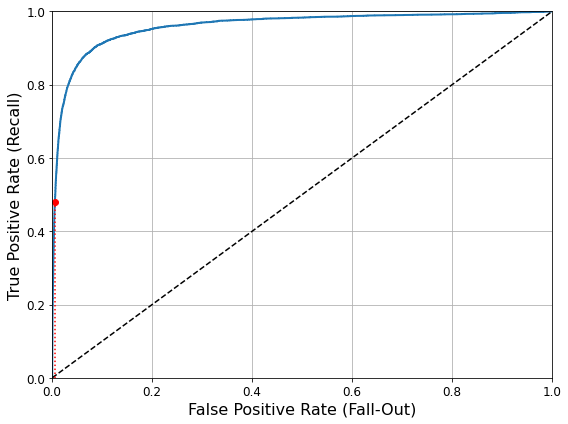

In [45]:
# Visualisiere die ROC-Kurve
# Abbildung 3-6. Diese ROC-Kurve stellt die Falsch-Positiv-Rate gegen die Wahr-Positiv-Rate für alle möglichen Schwellenwerte dar; 
# der rote Kreis hebt das gewählte Verhältnis hervor (bei 47,9 % Recall)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

# Erst die Visualisierung
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)

# Füge anschließend wieder eine Markierung für den Fall 90 % Precision/47,9 % Recall ein
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

Auch hier gibt es einen Trade-off: Je höher die Wiedererkennung (TPR), desto mehr falsch-positive Ergebnisse (FPR) produziert der Klassifikator. Die gepunktete Linie stellt die ROC-Kurve eines rein zufälligen Klassifikators dar; ein guter Klassifikator bleibt so weit wie möglich von dieser Linie entfernt (in Richtung der oberen linken Ecke).

Eine Möglichkeit, Klassifikatoren zu vergleichen, ist die Messung der Fläche unter der Kurve (AUC). Ein perfekter Klassifikator hat eine ROC AUC gleich 1, während ein rein zufälliger Klassifikator eine ROC AUC gleich 0,5 hat. Scikit-Learn bietet eine Funktion zur Berechnung der ROC AUC:

In [46]:
# Importiere die Funktion `roc_auc_score` von sklearn und Berechne die ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> Da die ROC-Kurve der Precision-/Recall-Kurve (PR-Kurve) so ähnlich ist, fragen Sie sich vielleicht, wie Sie entscheiden sollen, welche Kurve Sie verwenden sollen. Als Faustregel gilt, dass Sie die PR-Kurve immer dann bevorzugen sollten, wenn die positive Klasse selten ist oder wenn Sie sich mehr um die falsch-positiven als um die falsch-negativen Ergebnisse sorgen. Ansonsten sollten Sie die ROC-Kurve verwenden. Wenn Sie zum Beispiel die vorherige ROC-Kurve (und den ROC-AUC-Wert) betrachten, könnten Sie denken, dass der Klassifikator wirklich gut ist. Das liegt aber vor allem daran, dass es nur wenige Positive (5er) im Vergleich zu den Negativen (Nicht-5er) gibt. Im Gegensatz dazu macht die PR-Kurve deutlich, dass der Klassifikator verbesserungsfähig ist (die Kurve könnte näher an der oberen rechten Ecke liegen).

**Beachte**: wir setzen `n_estimators=100`, um zukunftssicher zu sein, da dies der Standardwert in Scikit-Learn ab Version 0.22 sein wird.

Lassen Sie uns nun einen `RandomForestClassifier` trainieren und seine ROC-Kurve und seinen ROC-AUC-Wert mit denen des SGDClassifier vergleichen. Zunächst müssen Sie die Werte für jede Instanz im Trainingssatz ermitteln. Aufgrund ihrer Funktionsweise (siehe Kapitel 7) verfügt die Klasse `RandomForestClassifier` jedoch nicht über eine `decision_function()`-Methode. Stattdessen hat sie eine `predict_proba()`-Methode. Scikit-Learn-Klassifikatoren haben in der Regel entweder die eine oder die andere oder beide. Die Methode `predict_proba()` gibt ein Array zurück, das eine Zeile pro Instanz und eine Spalte pro Klasse enthält, die jeweils die Wahrscheinlichkeit enthalten, dass die gegebene Instanz zu der gegebenen Klasse gehört (z.B. 70% Wahrscheinlichkeit, dass das Bild eine 5 darstellt):

In [47]:
# Trainiere einen RF Klassifikator und erzeuge Vorhersagen mit CV
# RF haben keine `decision_function`, stattdessen nutzen wir `predict_proba`
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [48]:
# Struktur von y_probas_forest verstehen
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [49]:
# Für die ROC Kurve brauchen wir die Vorhersagewahrscheinlichkeit einer Klasse, uns ist überlassen welche
# Wir erstellen eine ROC Kurve für die positive Klasse 
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


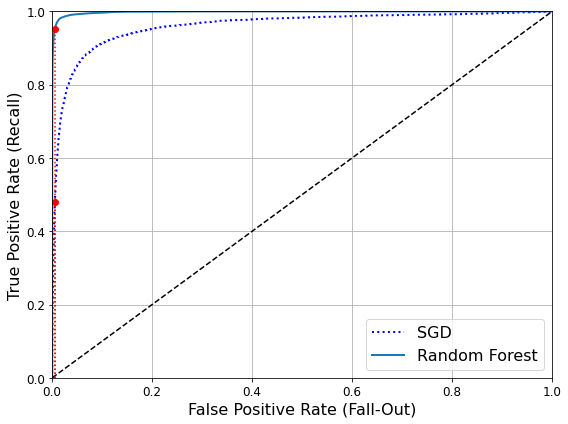

In [50]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")


plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")

Wie Sie in Abbildung 3-7 sehen können, sieht die ROC-Kurve des `RandomForestClassifier` viel besser aus als die des `SGDClassifier`: Sie liegt viel näher an der linken oberen Ecke. Infolgedessen ist auch sein ROC-AUC-Wert deutlich besser:

In [51]:
# Bestimme den ROC AUC Wert für RF Klassifikator
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Versuchen Sie, die Werte für die Genauigkeit und den Abruf zu messen: Sie sollten 99,0 % Genauigkeit und 86,6 % Abruf finden. Gar nicht so schlecht!

In [52]:
# Bestimme die Precision für RF via 3-fold CV
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [53]:
# Bestimme den Recall für RF via 3-fold CV
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

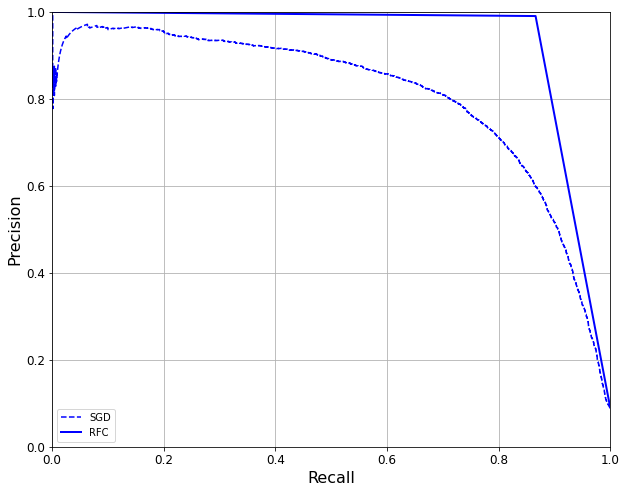

In [54]:
# Übung: Erstelle auch die precision-recall Kurve
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_train_pred_forest)

plt.figure(figsize=(10, 8))
plt.plot(recalls, precisions, "b--", label="SGD")
plot_precision_vs_recall(precisions_forest, recalls_forest, "RFC")
plt.legend(loc="lower left")

Sie wissen nun, wie Sie binäre Klassifizierer trainieren, die geeignete Metrik für Ihre Aufgabe auswählen, Ihre Klassifizierer mithilfe von Kreuzvalidierung evaluieren, den für Sie passenden Kompromiss zwischen Präzision und Wiedererkennung wählen und ROC-Kurven und ROC-AUC-Werte zum Vergleich verschiedener Modelle verwenden können. Lassen Sie uns nun versuchen, mehr als nur die 5er zu erkennen.

# Multiklassen-Klassifizierung

Während binäre Klassifikatoren zwischen zwei Klassen unterscheiden, können Multiklassenklassifikatoren (auch Multinomialklassifikatoren genannt) zwischen mehr als zwei Klassen unterscheiden.

Einige Algorithmen (z. B. logistische Regressionsklassifikatoren, Random-Forest-Klassifikatoren und Naive Bayes-Klassifikatoren) sind von Haus aus in der Lage, mehrere Klassen zu unterscheiden. Andere (z. B. SGD-Klassifikatoren oder Support Vector Machine-Klassifikatoren) sind rein binäre Klassifikatoren. Es gibt jedoch verschiedene Strategien, mit denen Sie eine Mehrklassen-Klassifikation mit mehreren binären Klassifikatoren durchführen können.

Eine Möglichkeit, ein System zu erstellen, das die Ziffernbilder in 10 Klassen (von 0 bis 9) klassifizieren kann, besteht darin, 10 binäre Klassifikatoren zu trainieren, einen für jede Ziffer (einen 0-Detektor, einen 1-Detektor, einen 2-Detektor usw.). Wenn Sie dann ein Bild klassifizieren wollen, erhalten Sie die Entscheidungsergebnisse der einzelnen Klassifikatoren für dieses Bild und wählen die Klasse aus, deren Klassifikator das höchste Ergebnis liefert. Dies wird als **One-versus-the-rest (OvR)**-Strategie bezeichnet (auch One-versus-all genannt).

Eine andere Strategie besteht darin, für jedes Ziffernpaar einen binären Klassifikator zu trainieren: einen für die Unterscheidung von 0 und 1, einen anderen für die Unterscheidung von 0 und 2, einen weiteren für 1 und 2 und so weiter. Dies wird als **Eins-gegen-Eins-Strategie (OvO)** bezeichnet. Wenn es N Klassen gibt, müssen Sie N × (N - 1) / 2 Klassifikatoren trainieren. Für das MNIST-Problem bedeutet dies das Training von 45 binären Klassifikatoren! Wenn Sie ein Bild klassifizieren wollen, müssen Sie das Bild durch alle 45 Klassifikatoren laufen lassen und sehen, welche Klasse die meisten Duelle gewinnt. Der Hauptvorteil von OvO besteht darin, dass jeder Klassifikator nur auf dem Teil der Trainingsmenge trainiert werden muss, der den beiden Klassen entspricht, die er unterscheiden muss.

Einige Algorithmen (z. B. Support Vector Machine-Klassifikatoren) skalieren schlecht mit der Größe der Trainingsmenge. Für diese Algorithmen wird OvO bevorzugt, weil es schneller ist, viele Klassifikatoren auf kleinen Trainingsmengen zu trainieren als wenige Klassifikatoren auf großen Trainingsmengen. Für die meisten binären Klassifikationsalgorithmen wird jedoch OvR bevorzugt.

Scikit-Learn erkennt, wenn Sie versuchen, einen binären Klassifizierungsalgorithmus für eine Multiklassen-Klassifizierungsaufgabe zu verwenden, und führt **automatisch OvR oder OvO** aus, je nach Algorithmus. Versuchen wir dies mit einem Support Vector Machine-Klassifikator (siehe Kapitel 5) unter Verwendung der Klasse sklearn.svm.SVC:

In [55]:
# Trainiere eine SVM als Klassifikator auf dem gesamten Trainingsdatensatz (nicht mehr nur auf 5er)
from sklearn.svm import SVC

subset = 5000 # Laufzeit ist deutlich länger für den gesamten Trainingsdatensatz, daher bei Bedarf weniger Beispiele benutzen!
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:subset], y_train[:subset]) # y_train, not y_train_5, 
svm_clf.predict([some_digit]) # Vorhersage ist dennoch korrekt!

array([5], dtype=uint8)

Das war einfach! Dieser Code trainiert den SVC auf der Trainingsmenge unter Verwendung der ursprünglichen Zielklassen von 0 bis 9 (y_train) anstelle der Zielklassen 5 gegen den Rest (y_train_5). Dann macht er eine Vorhersage (in diesem Fall eine richtige). Unter der Haube verwendet Scikit-Learn tatsächlich die OvO-Strategie: Es trainiert 45 binäre Klassifikatoren, ermittelt deren Entscheidungswerte für das Bild und wählt die Klasse aus, die die meisten Duelle gewonnen hat.

Wenn Sie die Methode `decision_function()` aufrufen, werden Sie sehen, dass sie 10 Werte pro Instanz zurückgibt (statt nur einen). Das ist eine Punktzahl pro Klasse (es ist die Anzahl der gewonnenen Duelle plus oder minus einer kleinen Änderung, um Unentschieden zu brechen, basierend auf den binären Klassifikator-Punktzahlen):

In [56]:
# Nutze die `decision_function` von SVM um die einzelnen Scores pro Klasse zu erhalten
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 0.80692283,  8.03544974,  1.81806847,  2.8249906 ,  5.91497318,
         9.29514788,  4.83731058,  6.97237517, -0.21039558,  3.82792163]])

In [57]:
# Welche Klassen hat die SVM gelernt? Welche Klasse wird für some_digit vorhergesagt?
predicted_class = np.argmax(some_digit_scores)
print(svm_clf.classes_)
svm_clf.classes_[predicted_class]

[0 1 2 3 4 5 6 7 8 9]


5

Wenn Sie Scikit-Learn zwingen wollen, One-versus-one oder One-versus-the-rest zu verwenden, können Sie die Klassen `OneVsOneClassifier` oder `OneVsRestClassifier` verwenden. Erstellen Sie einfach eine Instanz und übergeben Sie dem Konstruktor einen Klassifikator (es muss nicht einmal ein binärer Klassifikator sein). In diesem Code wird beispielsweise ein Multiklassen-Klassifikator mit der OvR-Strategie auf der Grundlage eines SVC erstellt:

In [58]:
# Nutze explizit `OneVsRestClassifier` um die SVM als OvR zu trainieren
# Trainingszeit sollte deutlich von OvO abweichen
from sklearn.multiclass import OneVsRestClassifier

subset = 5000
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:subset], y_train[:subset])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
# Anzahl der trainierten Klasifikatoren kann im Attribut `.estimators_` abgefragt werden
len(ovr_clf.estimators_)

10

In [60]:
# Trainiere SGD für den gesamten Trainingsdatensatz
from sklearn.linear_model import SGDClassifier

subset = 5000
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train[:subset], y_train[:subset])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

Dieses Mal hat Scikit-Learn die OvR-Strategie unter der Haube verwendet: Da es 10 Klassen gibt, wurden 10 binäre Klassifikatoren trainiert. Die Methode `decision_function()` gibt nun einen Wert pro Klasse zurück. Schauen wir uns nun die Punktzahl an, die der SGD-Klassifikator jeder Klasse zugewiesen hat:

In [61]:
# Betrachte die Scores pro Klasse
sgd_clf.decision_function([some_digit])

array([[-1319644.0334316 , -1094450.22293128,  -477415.20666682,
          -13106.10131312, -1269452.57717759,    82661.50523942,
         -695502.52263771,  -781968.57959698,  -366826.32000484,
         -461749.07969019]])

**Warnung**: In Abhängigkeit Ihrer Hardware können die folgenden zwei Codezellen eine etwas längere Laufzeit haben.

In [62]:
# Evaluiere SGD mit CV und Genauigkeit als Metrik
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87955, 0.87375, 0.87995])

SGD erreicht über 84 % bei allen Testfalten. Wenn Sie einen zufälligen Klassifikator verwenden würden, kämen Sie auf eine Genauigkeit von 10 %, das ist also kein schlechtes Ergebnis, aber es geht noch viel besser. Eine einfache Skalierung der Eingaben (wie in Kapitel 2 beschrieben) erhöht die Genauigkeit auf über 89 %:

In [63]:
# Nutze einen StandardScaler um die Daten vor dem Training zu Skalieren
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/miay/miniconda3/envs/ml-mit-python/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.89535, 0.8994 , 0.89745])

# Fehleranalyse

Wäre dies ein echtes Projekt, würden Sie nun die Schritte in Ihrer Checkliste für Machine Learning-Projekte (siehe Anhang B) befolgen. Sie würden die Möglichkeiten der Datenaufbereitung untersuchen, mehrere Modelle ausprobieren (die besten in die engere Wahl nehmen und ihre Hyperparameter mit `GridSearchCV` feinabstimmen) und so viel wie möglich automatisieren. Wir gehen hier davon aus, dass Sie ein vielversprechendes Modell gefunden haben und Wege finden möchten, es zu verbessern. Eine Möglichkeit, dies zu tun, ist die Analyse der Fehlerarten, die das Modell macht.

Sehen Sie sich zunächst die Konfusionsmatrix an. Sie müssen Vorhersagen mit der Funktion `cross_val_predict()` machen und dann die Funktion `confusion_matrix()` aufrufen, genau wie Sie es zuvor getan haben:

In [64]:
# Nutze den trainierten SGD Klassifikator und erzeuge Vorhersagen für den Trainingsdatensatz
# Erzeuge dann daraus die Konfusionsmatrix 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

subset = 60000
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:subset], y_train[:subset], cv=3, n_jobs=8)
conf_mx = confusion_matrix(y_train[:subset], y_train_pred[:subset])
conf_mx

array([[5558,    0,   21,    5,    8,   45,   33,    5,  247,    1],
       [   0, 6394,   39,   24,    4,   45,    4,    8,  213,   11],
       [  27,   26, 5231,   92,   69,   26,   65,   36,  377,    9],
       [  23,   16,  116, 5218,    2,  200,   26,   39,  419,   72],
       [  11,   14,   47,   10, 5195,   12,   33,   25,  337,  158],
       [  25,   15,   29,  163,   52, 4441,   72,   14,  550,   60],
       [  30,   15,   44,    2,   43,   98, 5547,    4,  134,    1],
       [  21,    9,   51,   28,   49,   14,    3, 5684,  202,  204],
       [  17,   61,   48,   87,    3,  122,   24,   10, 5440,   39],
       [  23,   18,   29,   67,  114,   34,    1,  174,  399, 5090]])

Das sind eine Menge Zahlen. Es ist oft bequemer, sich eine Bilddarstellung der Konfusionsmatrix anzusehen, indem man die Matplotlib-Funktion `matshow()` verwendet:

In [65]:
# Schreibe eine Hilfsfunktion zum Plotten der Konfusionsmatrix
def plot_confusion_matrix(matrix, bw: bool = False):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    if bw:
        cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    else:
        cax = ax.matshow(matrix)  # plt.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    
    return fig

Saving figure confusion_matrix_plot


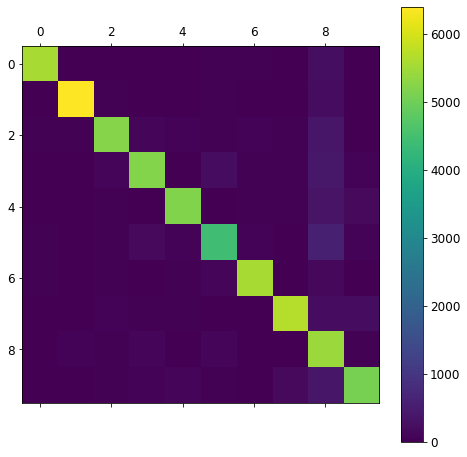

In [66]:
#plt.matshow(conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(conf_mx)
save_fig("confusion_matrix_plot", tight_layout=False)

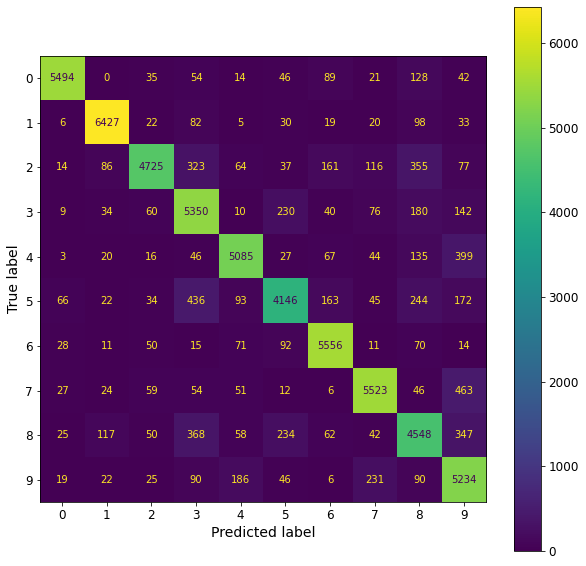

In [67]:
# since sklearn 0.22, you can use sklearn.metrics.ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_estimator(sgd_clf, X_train[:subset], y_train[:subset], ax=ax)

Konzentrieren wir uns bei der Darstellung auf die Fehler. Zunächst müssen Sie jeden Wert in der Konfusionsmatrix durch die Anzahl der Bilder in der entsprechenden Klasse teilen, damit Sie die Fehlerquoten und nicht die absoluten Fehlerzahlen vergleichen können (was dazu führen würde, dass reichlich vorhandene Klassen ungerechtfertigt schlecht aussehen):

In [68]:
# Wandle die Werte innerhalb der Konfusionsmatrix in Fehlerquoten um
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [69]:
# Setze alle Diagonaleinträge auf 0
np.fill_diagonal(norm_conf_mx, 0)

Saving figure confusion_matrix_errors_plot


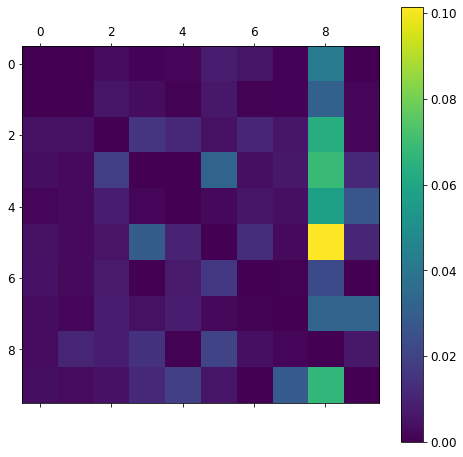

In [70]:
# Visualisiere die neue Konfusionsmatrix
plot_confusion_matrix(norm_conf_mx)
save_fig("confusion_matrix_errors_plot", tight_layout=False)

Sie können deutlich sehen, welche Arten von Fehlern der Klassifikator macht. Denken Sie daran, dass die Zeilen die tatsächlichen Klassen darstellen, während die Spalten die vorhergesagten Klassen repräsentieren. Die Spalte für die Klasse 8 ist ziemlich hell, was bedeutet, dass viele Bilder als 8er falsch klassifiziert werden. Die Zeile für die Klasse 8 ist jedoch nicht so schlecht, was bedeutet, dass die tatsächlichen 8er im Allgemeinen richtig als 8er klassifiziert werden. Wie Sie sehen können, ist die Konfusionsmatrix nicht unbedingt symmetrisch. Sie können auch sehen, dass 3er und 5er oft verwechselt werden (in beide Richtungen).

Die Analyse der Konfusionsmatrix gibt Ihnen oft Aufschluss darüber, wie Sie Ihren Klassifikator verbessern können. Wenn man sich dieses Diagramm ansieht, scheint es, dass Sie Ihre Bemühungen darauf verwenden sollten, die falschen 8er zu reduzieren. Sie könnten zum Beispiel versuchen, mehr Trainingsdaten für Ziffern zu sammeln, die wie 8en aussehen (aber keine sind), damit der Klassifikator lernen kann, sie von echten 8en zu unterscheiden. Oder Sie könnten neue Merkmale entwickeln, die dem Klassifikator helfen würden - zum Beispiel einen Algorithmus schreiben, der die Anzahl der geschlossenen Schleifen zählt (z. B. 8 hat zwei, 6 hat eine, 5 hat keine). Oder Sie könnten die Bilder vorverarbeiten (z. B. mit Scikit-Image, Pillow oder OpenCV), um bestimmte Muster, wie z. B. geschlossene Schleifen, deutlicher hervorzuheben.

Die Analyse einzelner Fehler kann ebenfalls ein guter Weg sein, um Erkenntnisse darüber zu gewinnen, was Ihr Klassifikator tut und warum er scheitert, ist aber schwieriger und zeitaufwändiger. Lassen Sie uns zum Beispiel Beispiele für 3er und 5er plotten (die Funktion `plot_digits()` verwendet einfach die Funktion `imshow()` von Matplotlib; Siehe Anfang Notebook):

Saving figure error_analysis_digits_plot


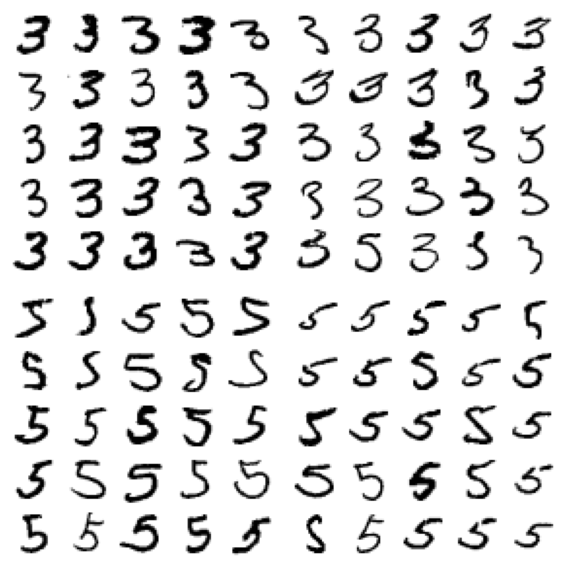

In [71]:
# Analysiere Fehlerbild 3 und 5: Zeige Block mit 3 die als 5 erkannt wurden und 5 die als 3 erkannt wurden
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

Der Hauptunterschied zwischen 3 und 5 ist die Position der kleinen Linie, die die obere Linie mit dem unteren Bogen verbindet. Wenn Sie eine 3 zeichnen, bei der die Verbindungslinie leicht nach links verschoben ist, könnte der Klassifikator sie als 5 einstufen und umgekehrt. Mit anderen Worten: Dieser Klassifikator reagiert sehr empfindlich auf Bildverschiebungen und Drehungen. Eine Möglichkeit, die 3/5-Verwechslung zu verringern, wäre also, die Bilder vorzubearbeiten, um sicherzustellen, dass sie gut zentriert und nicht zu stark gedreht sind. Dies wird wahrscheinlich auch dazu beitragen, andere Fehler zu reduzieren.

# Multilabel-Klassifizierung

Bis jetzt wurde jede Instanz immer nur einer Klasse zugewiesen. In einigen Fällen möchten Sie vielleicht, dass Ihr Klassifikator mehrere Klassen für jede Instanz ausgibt. Nehmen wir einen Gesichtserkennungs-Klassifikator: Was soll er tun, wenn er mehrere Personen auf demselben Bild erkennt? Er sollte jeder erkannten Person ein Tag zuordnen. Angenommen, der Klassifikator wurde darauf trainiert, drei Gesichter zu erkennen: Alice, Bob und Charlie. Wenn dem Klassifikator dann ein Bild von Alice und Charlie gezeigt wird, sollte er [1, 0, 1] ausgeben (was bedeutet: "Alice ja, Bob nein, Charlie ja"). Ein solches Klassifizierungssystem, das mehrere binäre Tags ausgibt, wird als **Multilabel-Klassifizierungssystem** bezeichnet.

In [72]:
# Demo Beispiel: Erzeuge ein Label für Zahl größer gleich 7 (7,8,9) und ein label für Zahl ungerade (1,3,5,7,9)
# Nutze einen KNN Klassifikator, um das Multilabel Problem zu lösen
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
# Verhersagen mit KNN
knn_clf.predict([some_digit])

array([[False,  True]])

Und es ist richtig! Die Ziffer 5 ist tatsächlich nicht groß (Falsch) und ungerade (Richtig).

Es gibt viele Möglichkeiten, einen Multilabel-Klassifikator zu bewerten, und die Wahl der richtigen Metrik hängt wirklich von Ihrem Projekt ab. Ein Ansatz ist die Messung des F1-Scores für jedes einzelne Label (oder jede andere binäre Klassifikator-Metrik, die zuvor besprochen wurde) und die anschließende Berechnung des Durchschnittsscores. Dieser Code berechnet den durchschnittlichen F1-Score für alle Labels:

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=8)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput-Klassifizierung

Die letzte Art von Klassifizierungsaufgabe, die wir hier erörtern, wird als Multioutput-Multiklassen-Klassifizierung (oder einfach Multioutput-Klassifizierung) bezeichnet. Es handelt sich dabei um eine Verallgemeinerung der Multilabel-Klassifikation, bei der jedes Label mehrere Klassen haben kann (d. h. es kann mehr als zwei mögliche Werte haben).

Um dies zu veranschaulichen, wollen wir ein System zur Entfernung von Rauschen aus Bildern entwickeln. Es nimmt als Eingabe ein verrauschtes Zahlenbild und gibt (hoffentlich) ein sauberes Zahlenbild aus, das als Array von Pixelintensitäten dargestellt wird, genau wie die MNIST-Bilder. Beachten Sie, dass die Ausgabe des Klassifikators mehrstufig ist (eine Stufe pro Pixel) und jede Stufe mehrere Werte haben kann (Pixelintensität reicht von 0 bis 255). Es handelt sich also um ein Beispiel für ein Klassifizierungssystem mit mehreren Ausgängen.

Beginnen wir mit der Erstellung der Trainings- und Testmengen, indem wir die MNIST-Bilder nehmen und mit der NumPy-Funktion `randint()` Rauschen zu ihren Pixelintensitäten hinzufügen. Die Zielbilder werden die Originalbilder sein:

In [75]:
# Wir fügen zu jedem Trainingsbild ein Rauschen hinzu
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Außerdem ist das target jetzt selbst ein Bild, nicht mehr nur ein Label!
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


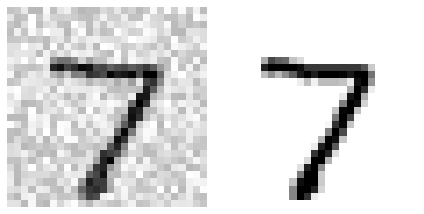

In [76]:
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])

plt.subplot(122)
plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


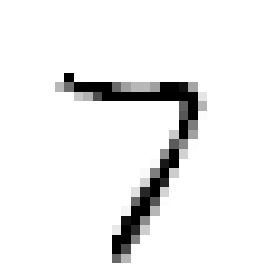

In [77]:
# Wir trainieren ein KNN Model für diese Aufgabe
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

Sieht nah genug am Ziel aus! Damit ist unser Rundgang durch die Klassifikation abgeschlossen. Sie sollten nun wissen, wie man gute Metriken für Klassifizierungsaufgaben auswählt, den richtigen Kompromiss zwischen Genauigkeit und Wiedererkennung findet, Klassifizierer vergleicht und ganz allgemein gute Klassifizierungssysteme für eine Vielzahl von Aufgaben erstellt.

# Zusatzmaterial

## Dummy (ie. random) classifier

In [78]:
from sklearn.dummy import DummyClassifier
y_train_5 = np.where(y_train == 5, 1, 0)
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

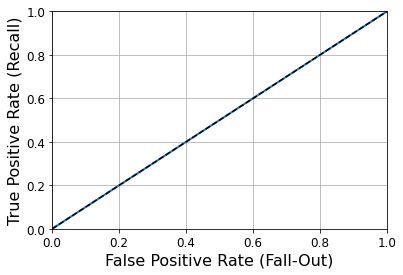

In [79]:
from sklearn.metrics import roc_curve
 
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [80]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [81]:
y_knn_pred = knn_clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714

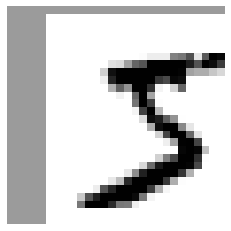

In [83]:
from scipy.ndimage import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [84]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [85]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [86]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [87]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [88]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

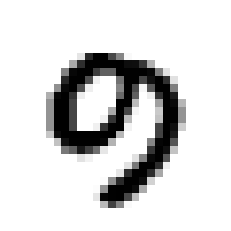

In [89]:
plot_digit(ambiguous_digit)

# Exercise solutions

## 1. An MNIST Classifier With Over 97% Accuracy

Aufgabe: Versuchen Sie, einen Klassifikator für den MNIST-Datensatz zu erstellen, der eine Genauigkeit von über 97 % auf dem Testsatz erreicht. Tipp: Der `KNeighborsClassifier` funktioniert für diese Aufgabe recht gut; Sie müssen nur gute Hyperparameterwerte finden (versuchen Sie eine Rastersuche für die Hyperparameter Gewichte und `n_neighbors`).

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=8)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.970 total time= 1.3min
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.969 total time= 1.3min
[CV 2/3] END ....n_neighbors=3, weights=uniform;, score=0.968 total time= 1.3min
[CV 3/3] END ....n_neighbors=3, weights=uniform;, score=0.968 total time= 1.3min
[CV 1/3] END ....n_neighbors=3, weights=uniform;, score=0.969 total time= 1.3min
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.969 total time= 1.3min
[CV 1/3] END ....n_neighbors=4, weights=uniform;, score=0.966 total time= 1.3min
[CV 2/3] END ....n_neighbors=4, weights=uniform;, score=0.966 total time= 1.3min
[CV 1/3] END ...n_neighbors=4, weights=distance;, score=0.971 total time= 1.3min
[CV 2/3] END ...n_neighbors=4, weights=distance;, score=0.970 total time= 1.3min
[CV 3/3] END ....n_neighbors=4, weights=uniform;, score=0.967 total time= 1.3min
[CV 3/3] END ...n_neighbors=4, weights=distance;,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [91]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [92]:
grid_search.best_score_

0.9703500000000002

In [93]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Data Augmentation

Aufgabe: Schreiben Sie eine Funktion, die ein MNIST-Bild in eine beliebige Richtung (links, rechts, oben oder unten) um ein Pixel verschieben kann. Erstellen Sie dann für jedes Bild in der Trainingsmenge vier verschobene Kopien (eine pro Richtung) und fügen Sie sie der Trainingsmenge hinzu. Schließlich trainieren Sie Ihr bestes Modell auf diesem erweiterten Trainingssatz und messen seine Genauigkeit auf dem Testsatz. Sie werden feststellen, dass Ihr Modell jetzt noch besser funktioniert! Diese Technik der künstlichen Vergrößerung des Trainingssatzes wird als Datenerweiterung oder Trainingssatzerweiterung bezeichnet.

In [94]:
from scipy.ndimage import shift

In [95]:
shift?

Signature:
shift(
    input,
    shift,
    output=None,
    order=3,
    mode='constant',
    cval=0.0,
    prefilter=True,
)
Docstring:
Shift an array.

The array is shifted using spline interpolation of the requested order.
Points outside the boundaries of the input are filled according to the
given mode.

Parameters
----------
input : array_like
    The input array.
shift : float or sequence
    The shift along the axes. If a float, `shift` is the same for each
    axis. If a sequence, `shift` should contain one value for each axis.
output : array or dtype, optional
    The array in which to place the output, or the dtype of the
    returned array. By default an array of the same dtype as input
    will be created.
order : int, optional
    The order of the spline interpolation, default is 3.
    The order has to be in the range 0-5.
mode : {'reflect', 'grid-mirror', 'constant', 'grid-constant', 'nearest',            'mirror', 'grid-wrap', 'wrap'}, optional
    The `mode` parameter

In [96]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

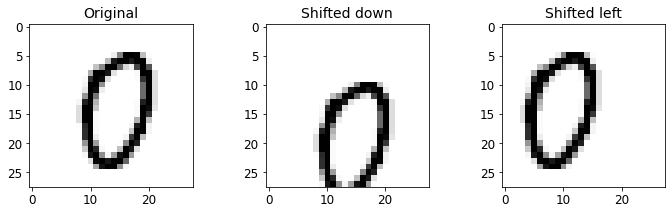

In [97]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [98]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [99]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [100]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [101]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

**Warnung**: Die Ausführung der folgenden Zelle kann je nach Ihrer Hardware bis zu einer Stunde dauern.

In [102]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

By simply augmenting the data, we got a 0.5% accuracy boost. :)

## 3. Tackle the Titanic dataset

Aufgabe: Nehmen Sie den Titanic-Datensatz in Angriff. Ein guter Startpunkt ist [Kaggle](https://www.kaggle.com/c/titanic).

Ziel ist es, anhand von Merkmalen wie Alter, Geschlecht, Passagierklasse, Einschiffungsort usw. vorherzusagen, ob ein Passagier überlebt hat oder nicht.

Holen wir uns die Daten und laden sie:

In [104]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Die Daten sind bereits in einen Trainingssatz und einen Testsatz aufgeteilt. Die Testdaten enthalten jedoch *nicht* die Bezeichnungen: Ihr Ziel ist es, mit den Trainingsdaten das bestmögliche Modell zu trainieren, dann Ihre Vorhersagen anhand der Testdaten zu treffen und sie bei Kaggle hochzuladen, um Ihre endgültige Punktzahl zu ermitteln.

Werfen wir einen Blick auf die obersten Zeilen des Trainingssatzes:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Die Attribute haben die folgende Bedeutung:

- **PassengerId**: eine eindeutige Kennung für jeden Passagier
- **Survived**: das ist das Ziel, 0 bedeutet, dass der Passagier nicht überlebt hat, während 1 bedeutet, dass er/sie überlebt hat.
-  **Pclass**: Klasse des Passagiers.
- **Name**, **Geschlecht**, **Alter**: selbsterklärend
- **SibSp**: wie viele Geschwister und Ehegatten des Passagiers an Bord der Titanic.
- **Parch**: wie viele Kinder & Eltern des Passagiers an Bord der Titanic.
- **Ticket**: Fahrscheinnummer
- **Fahrpreis**: gezahlter Preis (in Pfund)
- **Kabine**: Kabinennummer des Passagiers
- **Embarked**: wo der Passagier an Bord der Titanic gegangen ist

Legen wir die Spalte "PassengerId" explizit als Indexspalte fest:

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Lassen Sie uns mehr Informationen einholen, um zu sehen, wie viele Daten fehlen:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

Okay, die Attribute **Alter**, **Kabine** und **Eingebucht** sind manchmal null (weniger als 891 nicht-null), insbesondere **Kabine** (77 % sind null). Wir ignorieren das Attribut **Kabine** vorerst und konzentrieren uns auf die übrigen Attribute. Das Attribut **Alter** hat etwa 19 % Nullwerte, so dass wir entscheiden müssen, was damit geschehen soll. Das Ersetzen der Nullwerte durch den Altersmedian erscheint sinnvoll. Wir könnten etwas schlauer sein, indem wir das Alter auf der Grundlage der anderen Spalten vorhersagen (z. B. liegt das Medianalter in der ersten Klasse bei 37, in der zweiten Klasse bei 29 und in der dritten Klasse bei 24), aber wir halten es einfach und verwenden nur das Gesamtmedianalter.

Die Attribute **Name** und **Ticket** können einen gewissen Wert haben, aber es wird etwas schwierig sein, sie in nützliche Zahlen umzuwandeln, die ein Modell verwenden kann. Daher werden wir sie vorerst ignorieren.

Werfen wir einen Blick auf die numerischen Attribute:

In [ ]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Huch, nur 38 % **überlebten**! 😭 Das ist nahe genug an 40 %, so dass die Genauigkeit ein angemessener Maßstab für die Bewertung unseres Modells sein wird.
* Der durchschnittliche **Fahrpreis** lag bei 32,20 £, was nicht so teuer erscheint (aber damals war es wahrscheinlich eine Menge Geld).
* Das durchschnittliche **Alter** war weniger als 30 Jahre alt.

Überprüfen wir, ob das Ziel tatsächlich 0 oder 1 ist:

In [ ]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Werfen wir nun einen kurzen Blick auf alle kategorischen Attribute:

In [ ]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Das Attribut "Eingeschifft" gibt an, wo der Passagier eingeschifft wurde: C=Cherbourg, Q=Queenstown, S=Southampton.

Lassen Sie uns nun unsere Vorverarbeitungspipelines aufbauen, beginnend mit der Pipeline für numerische Attribute:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Jetzt können wir die Pipeline für die kategorischen Attribute erstellen:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

Zum Schluss wollen wir die numerischen und kategorischen Pipelines zusammenführen:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Super! Jetzt haben wir eine schöne Vorverarbeitungspipeline, die die Rohdaten nimmt und numerische Eingangsmerkmale ausgibt, die wir in jedes beliebige Machine Learning-Modell einspeisen können.

In [ ]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Vergessen wir nicht, die Labels ebenfalls abzuspeichern:

In [ ]:
y_train = train_data["Survived"]

Wir sind nun bereit, einen Klassifikator zu trainieren. Beginnen wir mit einem `RandomForestClassifier`:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Großartig, unser Modell ist trainiert, verwenden wir es, um Vorhersagen für den Testsatz zu treffen:

In [ ]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

Und jetzt könnten wir einfach eine CSV-Datei mit diesen Vorhersagen erstellen (unter Beachtung des von Kaggle vorgegebenen Formats), sie hochladen und auf das Beste hoffen. Aber halt! Wir können mehr tun als nur hoffen. Warum verwenden wir nicht eine Kreuzvalidierung, um eine Vorstellung davon zu bekommen, wie gut unser Modell ist?

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

Okay, gar nicht so schlecht! Wenn man sich das [Leaderboard](https://www.kaggle.com/c/titanic/leaderboard) für den Titanic-Wettbewerb auf Kaggle anschaut, kann man sehen, dass unsere Punktzahl unter den ersten 2% liegt, woohoo! Einige Kaggler erreichten eine Genauigkeit von 100 %, aber da man die [Liste der Opfer](https://www.encyclopedia-titanica.org/titanic-victims/) der Titanic leicht finden kann, scheint es wahrscheinlich, dass bei ihrer Leistung wenig Machine Learning im Spiel war! 😆

Versuchen wir es mit einem `SVC`:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Großartig! Dieses Modell sieht besser aus.

Aber anstatt nur die mittlere Genauigkeit über die 10 Kreuzvalidierungs-Folds zu betrachten, lassen Sie uns alle 10 Ergebnisse für jedes Modell zusammen mit einem Boxplot, der das untere und obere Quartil hervorhebt, und "Whiskern", die das Ausmaß der Ergebnisse zeigen, darstellen (Dank an Nevin Yilmaz für den Vorschlag dieser Visualisierung). Beachten Sie, dass die Funktion `boxplot()` Ausreißer (so genannte "fliers") erkennt und sie nicht in die Whiskers einbezieht. Wenn das untere Quartil $Q_1$ und das obere Quartil $Q_3$ ist, dann ist der Interquartilsbereich $IQR = Q_3 - Q_1$ (das ist die Höhe der Box), und jede Punktzahl, die kleiner als $Q_1 - 1,5 \times IQR$ ist, ist ein Ausreißer, ebenso wie jede Punktzahl, die größer als $Q3 + 1,5 \times IQR$ ist.

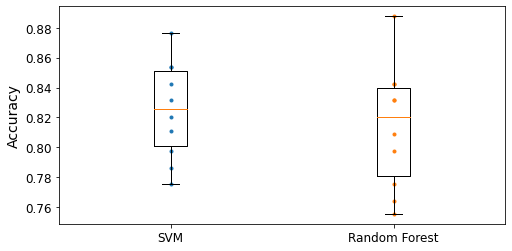

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Der Random-Forest-Klassifikator erhielt bei einer der 10 Faltungen eine sehr hohe Punktzahl, aber insgesamt hatte er einen niedrigeren Mittelwert und eine größere Streuung, so dass es den Anschein hat, dass der SVM-Klassifikator eher gut verallgemeinern kann.

Um dieses Ergebnis weiter zu verbessern, könnten Sie:

* Viele weitere Modelle vergleichen und die Hyperparameter mit Hilfe von Kreuzvalidierung und Rastersuche abstimmen,
* Mehr Feature-Engineering betreiben, zum Beispiel:
  * Versuchen Sie, numerische Attribute in kategorische Attribute umzuwandeln: Zum Beispiel hatten verschiedene Altersgruppen sehr unterschiedliche Überlebensraten (siehe unten), so dass es hilfreich sein könnte, eine Alterskategorie zu erstellen und diese anstelle des Alters zu verwenden. Ebenso kann es sinnvoll sein, eine spezielle Kategorie für Alleinreisende zu erstellen, da nur 30 % von ihnen überlebten (siehe unten).
  * Ersetzen Sie **SibSp** und **Parch** durch ihre Summe.
  * Versuchen Sie, Teile von Namen zu identifizieren, die gut mit dem Attribut **Überlebt** korrelieren.
  * Verwenden Sie die Spalte **Kabine**, nehmen Sie z.B. den ersten Buchstaben und behandeln Sie ihn als kategorisches Attribut.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. Spam classifier

Aufgabe: Erstellen Sie einen Spam-Klassifikator (eine anspruchsvollere Übung)

1. Laden Sie Beispiele für Spam und Schinken aus den öffentlichen Datensätzen von [Apache SpamAssassin](https://homl.info/spamassassin) herunter.

2. Entpacken Sie die Datensätze und machen Sie sich mit dem Datenformat vertraut.

3. Teilen Sie die Datensätze in einen Trainingssatz und einen Testsatz auf.

4. Schreiben Sie eine Datenvorbereitungspipeline, um jede E-Mail in einen Merkmalsvektor zu konvertieren. Ihre Aufbereitungspipeline sollte eine E-Mail in einen (sparse) Vektor umwandeln, der das Vorhandensein oder Fehlen jedes möglichen Wortes angibt. Wenn beispielsweise alle E-Mails nur vier Wörter enthalten, nämlich "Hallo", "wie", "sind" und "du", dann würde die E-Mail "Hallo du Hallo du" in einen Vektor [1, 0, 0, 1] (d. h. ["Hallo" ist vorhanden, "wie" ist nicht vorhanden, "sind" ist nicht vorhanden, "du" ist vorhanden]) oder [3, 0, 0, 2] umgewandelt, wenn Sie es vorziehen, die Anzahl der Vorkommen der einzelnen Wörter zu zählen.

   Sie können Ihrer Vorbereitungspipeline Hyperparameter hinzufügen, um zu steuern, ob E-Mail-Kopfzeilen entfernt, jede E-Mail in Kleinbuchstaben umgewandelt, Satzzeichen entfernt, alle URLs durch "URL" ersetzt, alle Zahlen durch "NUMBER" ersetzt oder sogar Stemming durchgeführt werden soll (d. h., dass Wortendungen abgeschnitten werden; es gibt Python-Bibliotheken, die dies ermöglichen).
  
   Probieren Sie schließlich mehrere Klassifikatoren aus, um zu sehen, ob Sie einen guten Spam-Klassifikator mit hoher Trefferquote und hoher Genauigkeit erstellen können.




Lassen Sie uns zunächst die Daten abrufen:

In [ ]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [ ]:
fetch_spam_data()

Als Nächstes müssen wir alle E-Mails laden:

In [ ]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [ ]:
len(ham_filenames)

2500

In [ ]:
len(spam_filenames)

500

Wir können das Python-Modul `email` verwenden, um diese E-Mails zu analysieren (es kümmert sich um Kopfzeilen, Kodierung und so weiter):

In [ ]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Schauen wir uns ein Beispiel für eine echte E-Mail und ein Beispiel für Spam an, um ein Gefühl dafür zu bekommen, wie die Daten aussehen:

In [ ]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [ ]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [ ]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Es scheint, dass die Ham-E-Mails häufiger aus reinem Text bestehen, während Spam ziemlich viel HTML enthält. Außerdem sind viele Ham-E-Mails mit PGP signiert, während dies bei Spam nicht der Fall ist. Kurzum, es scheint, dass die E-Mail-Struktur eine nützliche Information ist.

Werfen wir nun einen Blick auf die E-Mail-Kopfzeilen:

In [ ]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Es gibt wahrscheinlich eine Menge nützlicher Informationen, wie z. B. die E-Mail-Adresse des Absenders (12a1mailbot1@web.de sieht verdächtig aus), aber wir werden uns nur auf den `Subject`-Header konzentrieren:

In [ ]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Bevor wir zu viel über die Daten lernen, sollten wir sie in einen Trainings- und einen Testsatz aufteilen:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Okay, fangen wir an, die Vorverarbeitungsfunktionen zu schreiben. Zuerst brauchen wir eine Funktion, die HTML in einfachen Text umwandelt. Der beste Weg, dies zu tun, wäre wohl die Verwendung der großartigen [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) Bibliothek, aber ich möchte es vermeiden, diesem Projekt eine weitere Abhängigkeit hinzuzufügen, also lassen Sie uns eine schnelle & schmutzige Lösung mit regulären Ausdrücken hacken (auf die Gefahr hin, [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)).  Die folgende Funktion lässt zunächst den Abschnitt `<head>` weg, wandelt dann alle `<a>`-Tags in das Wort HYPERLINK um, entfernt dann alle HTML-Tags und lässt nur den reinen Text übrig. Um die Lesbarkeit zu verbessern, werden außerdem mehrere Zeilenumbrüche durch einfache Zeilenumbrüche ersetzt, und schließlich werden HTML-Entities (wie z. B. `&gt;` oder `&nbsp;`) unescaped:

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

Und das ist der resultierende Klartext:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Großartig! Schreiben wir nun eine Funktion, die eine E-Mail als Eingabe annimmt und ihren Inhalt als reinen Text zurückgibt, unabhängig von ihrem Format:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Fügen wir etwas Stemming hinzu! Damit dies funktioniert, müssen Sie das Natural Language Toolkit ([NLTK](http://www.nltk.org/)) installieren. Das geht ganz einfach, indem man den folgenden Befehl ausführt (vergessen Sie nicht, zuerst Ihre virtualenv zu aktivieren; wenn Sie keine haben, brauchen Sie wahrscheinlich Administratorrechte, oder Sie verwenden die Option `--user`):

`$ pip3 install nltk`

In [ ]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [ ]:
# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

**Note:** inside a Jupyter notebook, always use `%pip` instead of `!pip`, as `!pip` may install the library inside the wrong environment, while `%pip` makes sure it's installed inside the currently running environment.

In [ ]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.longlong'>'
	with 20 stored elements in Compressed Sparse Row format>

In [ ]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int64)

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [ ]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Note**: to be future-proof, we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.991, total=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


0.9858333333333333

Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%
